In [4]:
#### LIBRARIES NEEDED ####

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import time
import pandas as pd
import datetime
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn import linear_model, ensemble
from sklearn.linear_model import Lasso, Ridge,ElasticNet, BayesianRidge
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from functools import reduce
import glob
import matplotlib.pyplot as plt

In [2]:
#### FUNCTIONS ####


## Get Influenza's related words

def get_outlinks(url):
    '''This function takes the out links of a page given in url.
        /wiki is the starting tag of wikipedia pages
        PMID is the tag for counting the citations in a page (we are not interested about it)'''
    
    base_wiki_url = "https://it.wikipedia.org/wiki/"
    
    # Request the page
    page_response = requests.get(url)
    
    # Parse the page
    soup = BeautifulSoup(page_response.content, "html.parser")
    
    #Add out-links
    edges = []
    one_hop_links = []
    
    # Get neighbors of seed-url
    for link in soup.find_all('a'):
        temp = str(link.get('href'))
        if temp[0:5] == "/wiki" and "PMID" not in temp and ":" not in temp and "secolo" not in temp:
            try:
                int(temp[-4:])
            except:
                one_hop_links.append(temp[6:])
                edges.append(frozenset(["influenza", temp[6:]]))
    
    one_hop_links = list(set(one_hop_links))
    
    print(one_hop_links)
        
    for page in one_hop_links[:10]:
        
        url = base_wiki_url + page
        
        # Request the page
        page_response = requests.get(url)
        
        # Parse the page
        soup = BeautifulSoup(page_response.content, "html.parser")
        
        # Get neighbors of seed-url
        for link in soup.find_all('a'):
            temp = str(link.get('href'))
            if temp[0:5] == "/wiki" and "PMID" not in temp and ":" not in temp and "secolo" not in temp:
                try:
                    int(temp[-4:])
                except:
                    edges.append(frozenset([page, temp[6:]]))
    
    return edges

def get_data(words):
    
    if len(words) > 10:
        return print("No man, you can put just 10 words maximum")

    bs_url = "https://tools.wmflabs.org/pageviews/?project=it.wikipedia.org&platform=all-access&agent=user&range=all-time&pages="+"|".join(words)

    driver = webdriver.Chrome()
    driver.get(bs_url)
    
    time.sleep(10)

    first_click = driver.find_elements_by_tag_name("button")
    first_click[6].click()
    
    driver.find_element_by_class_name("download-csv").click()




# Pipeline

- Get Influenza's related words
- Get Data and Ground Truth
- Build Time Series
- Measure Correlation
- Model it!

### Get Influenza's related words

Explain what we're going to do

In [ ]:
# Starting Link
seed_url = "https://it.wikipedia.org/wiki/Influenza"

wiki_links = get_outlinks(seed_url)

In [ ]:
wiki_links

In [ ]:
a = [frozenset([4,5]),frozenset([4,5]),frozenset([5,6])]

In [ ]:
set(a)

### Get Data and Ground Truth

Wikipedia Data

In [5]:
### Flu_data Functions

def get_week_number(entire_date):
    return entire_date.date().isocalendar()[1]

def get_year(entire_date):
    return entire_date.year

def merge_df(a,b):
    return a.append(b)


### Influnet Functions

def get_year_influnet(date):
    return int(date[:4])

def get_week_influnet(date):
    return int(date[5:])

def match_data(year,week):
    val = gt["Incidence"].loc[(gt["Year"] == year) & (gt["Week"] == week)]
    return float(val)

In [6]:
#################### Useless to run this cell! data are already stored in data folder!!! ####################

# choosen manually now
related_words = ["influenza", "febbre", "paracetamolo", "antipiretico", "cortisone",
                 "ibuprofene", "tonsillite", "bronchite", "morbillo", "polmonite"]
#Download data
get_data(related_words)


In [7]:
# Read data
flu_data = pd.read_csv("data/flu_data.csv")

# Convert date to datetime
flu_data["Date"] = pd.to_datetime(flu_data["Date"], yearfirst=True)

# Get week number and year
flu_data["Week"] = flu_data["Date"].apply(get_week_number)
flu_data["Year"] = flu_data["Date"].apply(get_year)

# Group by week number and year
flu_data = flu_data.groupby(["Year", "Week"]).sum()
flu_data = flu_data.stack()

weeks_of_interest = {2015: [[42,53]], 2016: [[1,16], [42,52]], 2017: [[1,17], [42,52]], 2018: [[1,17]]}

# Merging Dataframes
temp = []
for k,v in weeks_of_interest.items():
    for elem in v:
        temp.append(flu_data.loc[k,list(range(elem[0],elem[1]+1))])
        
        
flu_data = reduce(merge_df, temp).unstack()

Influnet Data

In [8]:
# Take the csv files from influnet folder clean the dataframes and return a dataframe containing the ground truth
# the gt dataframe has two columns: the week and the incidence value

files = glob.glob("data/influnet/*")
temp_gt = []
for file in files:
    print("Adding file " + file + " ...")
    temp = pd.read_csv(file, header=None)
    temp = temp[[0,4]]
    temp = temp.drop(temp.index[0:3])
    temp = temp.replace(to_replace=",", value=".", regex=True)
    temp[4] = pd.to_numeric(temp[4])
    temp = temp.reset_index(drop=True)
    temp.columns=["Week","Incidence"]
    temp_gt.append(temp)

gt = pd.concat(temp_gt, axis=0, ignore_index=True)

Adding file data/influnet\influnet_1516.csv ...
Adding file data/influnet\influnet_1617.csv ...
Adding file data/influnet\influnet_1718.csv ...


In [9]:
gt["Year"] = gt["Week"].apply(get_year_influnet)
gt["Week"] = gt["Week"].apply(get_week_influnet)

In [10]:
flu_data["GT"] = ["0" for _ in range(flu_data.shape[0])]

In [11]:
flu_data = flu_data.stack()

In [12]:
for year in flu_data.index.levels[0]:
    for week in flu_data.index.levels[1]:
        try:
            flu_data.loc[year,[week],"GT"] = match_data(year,week)
        except:
            pass

In [13]:
flu_data = flu_data.unstack()

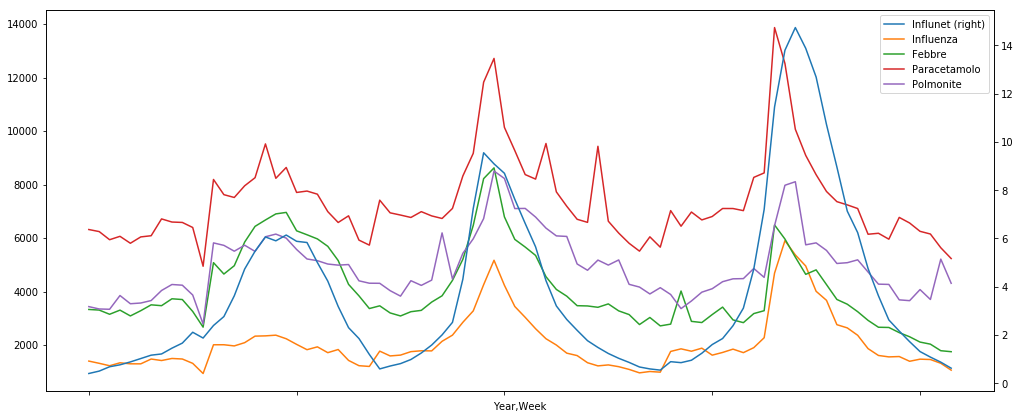

In [15]:
flu_data.GT.plot(secondary_y=True, label="Influnet", figsize=(17,7), legend=True)
flu_data.Influenza.plot(label="Influenza", legend=True)
flu_data.Febbre.plot(label="Febbre", legend=True)
flu_data.Paracetamolo.plot(label="Paracetamolo", legend=True)
flu_data.Polmonite.plot(label="Polmonite", legend=True)
plt.show()

## Evaluate the correlation

In [16]:
def corr(words):
    
    '''Evaluate the Pearson and the Spearman correlation among the list of words and the GT
        Return the dictionary with the correlated words (both corr > 0.5) and their values.'''
    
    corr = {}
    for word in words:
        if pearsonr(flu_data["GT"], flu_data[word])[0]>0.5 and spearmanr(flu_data["GT"], flu_data[word])[0]>0.5:
            corr[word] = [pearsonr(flu_data["GT"], flu_data[word])[0], spearmanr(flu_data["GT"], flu_data[word])[0]]
    return corr

In [17]:
corr_words = corr(list(flu_data.columns[:-1]))
corr_words

{'Antipiretico': [0.7795134437381952, 0.7692007836843181],
 'Bronchite': [0.6974484494578517, 0.7954499434645579],
 'Febbre': [0.6502940587680799, 0.672728101136027],
 'Influenza': [0.9205795256419326, 0.8380750852196114],
 'Paracetamolo': [0.7705959640324906, 0.7774824715504173],
 'Polmonite': [0.7546861680971892, 0.7946490496271684],
 'Tonsillite': [0.5404503660498178, 0.5566535381536143]}

## Part 3: The model

In [18]:
models = {}
models["Lasso"] = Lasso(alpha = 0.1)
models["Ridge"] = Ridge(alpha = 0.01)
models["Gradient_Boosting"] = GradientBoostingRegressor(n_estimators=1000)
models["ElasticNet"] = ElasticNet(alpha = 0.01)
models["Bayesian_Ridge"] = BayesianRidge()

In [19]:
def dataset_to_model(dataframe, predictors, shift=False):
    
    '''Create the datasets to be used in the model.
        shift = True used in point 3.2 for AutoRegressive models'''

    x = dataframe[predictors]
    x_test = np.asarray(x.loc[2018])
    if shift == True:
        x.drop(columns="GT1")
    x_train = np.asarray(x.loc[[2015, 2016, 2017]])
    y_train = dataframe.loc[[2015, 2016, 2017]][["GT"]]
    y_train = np.asarray(y_train).reshape(len(x_train), )
    y_test = np.asarray(dataframe.loc[2018][["GT"]]).reshape(len(x_test),)

    # Rescaling
    
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train = min_max_scaler.fit_transform(x_train)
    X_test = min_max_scaler.transform(x_test)
    X = min_max_scaler.fit_transform(x)
    
    return X_train, X_test, y_train, y_test, X

In [20]:
def model_selection(models, X_train, X_test, y_train, y_test, year_to_be_predicted):
    
    '''Return the best model.
        Apply grid search for parameters of the models given in input.
        Apply cross validation (specifically for Time Series).'''
    
    # Set initial params
    
    min_mse = 100
    max_r2 = 0
    
    # Set different parameters grid for the models
    
    for name, mod in models.items():
        if name in ["Lasso", "Ridge", "ElasticNet"]:
            param_search = {'alpha' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 1]}
        if name == "Gradient_Boosting":
            param_search = {'max_depth' : [2, 3, 4, 5]}
        if name == "Bayesian_Ridge":
            param_search = {'alpha_1' : [1e-9, 1e-8, 1e-7, 1e-6],
                            'alpha_2' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}
        
        # Apply Cross-Validation and GridSearch
        
        my_cv = TimeSeriesSplit(n_splits=5).split(X_train)
        gsearch = GridSearchCV(estimator=mod, cv=my_cv,
                            param_grid=param_search, n_jobs=-1)
        gsearch.fit(X_train, y_train)
        pred = gsearch.predict(X_test)
        
        # Evaluate predictions (MSE and R^2)
        
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        
        # Save the best model
        if mse < min_mse and r2 > max_r2:
            min_mse = mse
            max_r2 = r2
            best_model = gsearch

    return(best_model, name, min_mse, max_r2)

In [21]:
X_train, X_test, y_train, y_test, X = dataset_to_model(flu_data, ["Influenza", "Polmonite", "Bronchite", "Paracetamolo"])

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
best_model, name, min_mse, max_r2 = model_selection(models, X_train, X_test, y_train, y_test, 2018)

In [23]:
# Prediction on the overall dataset
pred = best_model.predict(np.asarray(X))
print("R2: " + str(r2_score(np.asarray(flu_data["GT"]).reshape(84,), pred)))
print("MSE: " + str(mean_squared_error(np.asarray(flu_data["GT"]).reshape(84,), pred)))

R2: 0.7928000808473674
MSE: 2.5257971870778655


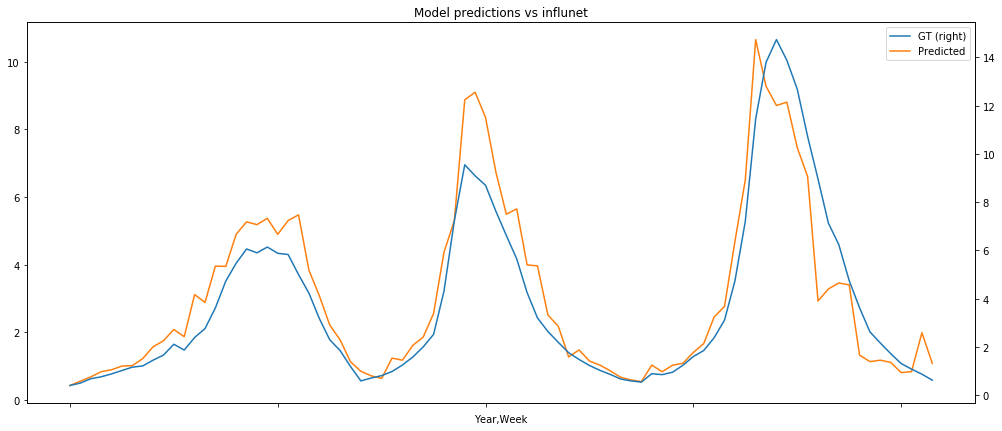

In [24]:
plot = flu_data.copy()
plot["Predicted_18"] = pred
plot.GT.plot(secondary_y=True, label="GT", figsize=(17,7), legend=True)
plt.title("Model predictions vs influnet")
plot.Predicted_18.plot(label="Predicted", legend=True)

### Part 3.2

In [25]:
def get_shift(col):
    
    '''Return the shifted serie of a given column.'''
    
    flu_serie = pd.Series(np.asarray(flu_data[[col]]).reshape(84,))
    serie = flu_serie.shift(1)
    return serie

def create_shift_dataset():
    
    '''Return the dataframe with the shifted columns.'''
    
    flu_AR1 = flu_data.copy()
    cols_list = list(corr_words.keys())
    cols_list.append('GT')
    for col in cols_list:
        flu_AR1[col+str(1)] = np.asarray(get_shift(col))
    flu_AR1 = flu_AR1.drop(flu_AR1.index[0])
    return flu_AR1

In [26]:
flu_AR1 = create_shift_dataset()

In [27]:
X_train, X_test, y_train, y_test, X = dataset_to_model(flu_AR1,
                                                       ["Influenza", "Polmonite", "Bronchite", "Paracetamolo",
                                                        "GT1", "Influenza1", "Polmonite1", "Bronchite1", "Paracetamolo1"],
                                                       shift=True)

best_model, name, min_mse, max_r2 = model_selection(models, X_train, X_test, y_train, y_test, 2018)

C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
# Prediction on the overall dataset
pred = best_model.predict(np.asarray(X))
print("R2: " + str(r2_score(np.asarray(flu_data["GT"][1:]).reshape(83,), pred)))
print("MSE: " + str(mean_squared_error(np.asarray(flu_data["GT"][1:]).reshape(83,), pred)))

R2: 0.7819297227018127
MSE: 2.6609076733114456


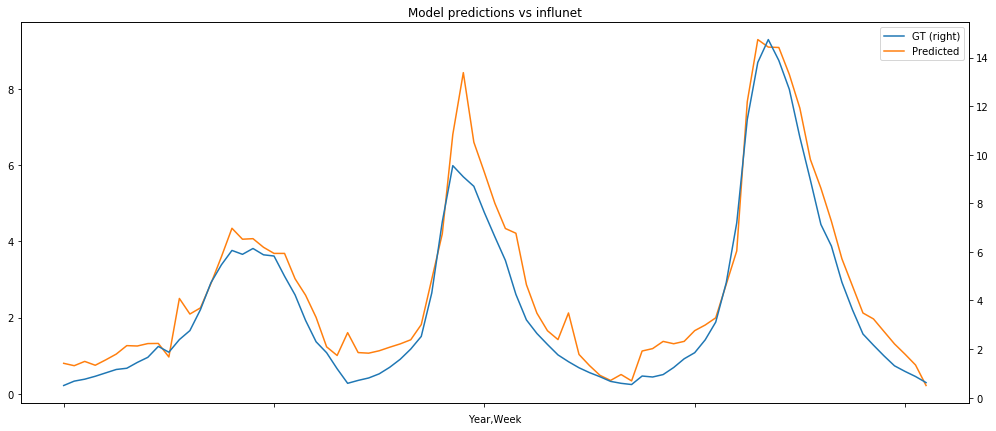

In [29]:
plot = flu_AR1.copy()
plot["Predicted_18"] = pred
plot.GT.plot(secondary_y=True, label="GT", figsize=(17,7), legend=True)
plt.title("Model predictions vs influnet")
plot.Predicted_18.plot(label="Predicted", legend=True)